## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

Мы начнем работать с нейронными сетями на практическом занятии. Вашим домашним заданием будет завершить реализацию слоев.

Наша цель проста, но фактическая реализация может занять некоторое время :). Мы собираемся написать искусственную нейронную сеть (почти) с нуля. Дизайн программного обеспечения был во многом вдохновлен [PyTorch](http://pytorch.org), который является основной основой нашего курса

Что касается домашнего задания (еще раз, оно будет очень похоже на этот семинар), то оно требует отправки ** нескольких ** файлов, пожалуйста, не забудьте указать все файлы при отправке в TA. Список файлов:
- Эта тетрадь
- modules.ipynb со всеми реализованными блоками (за исключением, возможно, реализации уровней `Conv2d` и `MaxPool2d`, которые являются частью "расширенной" версии этого домашнего задания)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Реализуйте все в `modules.ipynb`. Внимательно прочитайте все комментарии, чтобы облегчить задачу. Пожалуйста, постарайтесь не изменять прототипы.

Не забывайте, что каждый модуль должен возвращать ** И** сохранять `output` и `gradInput`.

Типичным предположением является то, что `module.backward` всегда выполняется после `module.forward`,
поэтому `output` сохраняется, это было бы полезно для `SoftMax`.

### Tech note
Лучше использовать `np.multiply`, `np.add`, `np.divide`, `np.subtract` вместо `*`,`+`,`/`,`-` для лучшей работы с паматью.

Например: предположим, что вы выделили переменную

```
a = np.zeros(...)
```
таким образом, вместо
```
a = b + c  # будет перераспределен, GC, необходимый для освобождения
``` 
вы можете использовать: 
```
np.add(b,c,out = a) # помещает результат в `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

ModuleNotFoundError: No module named 'nbformat'

# Toy example

Используйте этот пример для отладки вашего кода, начните с логистической регрессии, а затем протестируйте другие слои. Здесь вам не нужно ничего менять. Этот код предоставлен для тестирования слоев. Также этот код легко использовать в задаче MNIST.

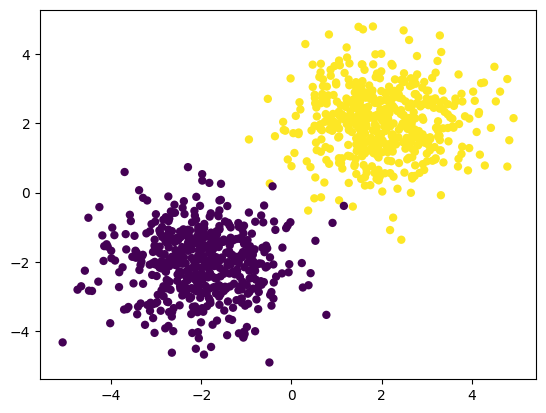

In [9]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Определите **логистическую регрессию** для отладки.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Начните с batch_size = 1000, чтобы убедиться, что каждый шаг снижает потери, затем попробуйте версию stochastic.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Базовый цикл обучения. Изучите его.

In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Классификация цифр

В качестве набора данных мы используем старый добрый [MNIST](http://yann.lecun.com/exdb/mnist/). Его можно загрузить вместе со следующим файлом.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

Сначала закодируйте метки через one-hot.

In [ ]:
# Your code goes here. ################################################

- **Сравните** функции активации `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus`. 
Вам лучше выбрать оптимальные параметры оптимизатора для каждой из них, но на данный момент это излишество. Для сравнения используйте архитектуру по вашему выбору.
- **Попробуйте** вставить `BatchNormalization` (за которой следует `ChannelwiseScalling`) между `Linear` модулем и функциями активации.
- Изобразите потери как от сравнения функций активации, так и от сравнения `BatchNormalization` на одном графике. Пожалуйста, найдите масштаб (логарифмический?) когда линии будут различимы, не забудьте назвать оси, график должен быть красивым.
- Постройте график потерь для двух сетей: одной, обученной momentum_sgd, и другой, обученной Adam. Какая из них работает лучше?
- Подсказка: хороший лог-лосс для MNIST должен составлять около 0,5.

In [ ]:
# Your code goes here. ################################################

Напишите свое личное мнение о функциях активации, а также подумайте о времени вычислений. Помогает ли `BatchNormalization`?

In [ ]:
# Your answer goes here. ################################################

**И, наконец,**, используйте все свои знания, чтобы построить супер крутую модель на основе этого набора данных. Используйте **Dropout**, чтобы предотвратить переобучение, поиграйте с **снижением скорости обучения**. Вы можете использовать **дополнительные данные**, такие как ротации, переводы, чтобы повысить свой результат. Используйте свои знания и воображение для обучения модели. Не забудьте вызвать методы `training()` и `evaluate()`, чтобы задать желаемое поведение уровней `BatchNormalization` и `Dropout`.

In [ ]:
# Your code goes here. ################################################

Укажите здесь вашу точность в тестовом наборе. Она должна составлять около 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
Последний (и, возможно, самый простой) шаг по сравнению с предыдущими задачами: создайте сеть с той же архитектурой, что и вышеописанная, теперь с помощью PyTorch.

__Good Luck!__

In [ ]:
# Your beautiful code here.